In [1]:
import tensorflow as tf

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL

In [80]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import Image,ImageDraw
from PIL.ImageDraw import Draw

In [25]:
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest')
os.getcwd()

'C:\\Users\\George\\Documents\\Python Scripts\\DeepTest'

In [152]:
#load dataset
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest\\TestSet')
bbs = pd.read_csv('bb.csv',header = None)
bbs = bbs.iloc[:1000]

train_images = []

#for i in range(len(train_targets)):
for i in range(1000):
    image_name = 'test_{}.png'.format(i)
    train_img = np.asarray(Image.open(image_name))    
    train_images.append(train_img)
    
train_targets = np.array(bbs,dtype = "float32")/164.0
train_images = np.array(train_images,dtype = "float32")/255.0

In [153]:
#load validation dataset
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest\\ValidationSet')
bbs = pd.read_csv('bb.csv',header = None)
bbs = bbs.iloc[:200]

val_images = []

#for i in range(len(train_targets)):
for i in range(200):
    image_name = 'test_{}.png'.format(i)
    val_img = np.asarray(Image.open(image_name))    
    val_images.append(val_img)
    
val_targets = np.array(bbs,dtype = "float32")/164.0
val_images = np.array(val_images,dtype = "float32")/255.0

In [154]:
#start model
height,width = 164,164
input_shape = (height,width,1) #grayscale
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers - maxpooling parameter - perhaps not necessary yet?
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

In [155]:
#create output layer
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [156]:
model = tf.keras.Model(input_layer,locator_branch)

In [157]:
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 164, 164, 1)]     0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 164, 164, 16)      160       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 82, 82, 16)        0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 82, 82, 32)        4640      
_________________________________________________________________
bl_5 (MaxPooling2D)          (None, 41, 41, 32)        0         
_________________________________________________________________
bl_6 (Conv2D)                (None, 41, 41, 64)        18496     
_________________________________________________________________
bl_7 (MaxPooling2D)          (None, 20, 20, 64)      

In [158]:
model.compile(loss = tf.keras.losses.MSE, optimizer = 'Adam', metrics = ['accuracy']) 

In [159]:
val_targets

array([[0.4207317 , 0.4817073 , 0.04268293, 0.14634146],
       [0.23170732, 0.08536585, 0.09146342, 0.13414635],
       [0.5       , 0.6890244 , 0.04878049, 0.23170732],
       [0.22560975, 0.06097561, 0.06097561, 0.15243903],
       [0.03658536, 0.35365853, 0.23780487, 0.04268293],
       [0.47560975, 0.34146342, 0.10365853, 0.01219512],
       [0.46341464, 0.15853658, 0.08536585, 0.18292683],
       [0.15853658, 0.20731707, 0.21341464, 0.03048781],
       [0.6585366 , 0.34146342, 0.1402439 , 0.09146342],
       [0.33536586, 0.2682927 , 0.11585366, 0.11585366],
       [0.70731705, 0.5304878 , 0.20731707, 0.08536585],
       [0.5304878 , 0.63414633, 0.05487805, 0.08536585],
       [0.09146342, 0.6585366 , 0.1097561 , 0.09146342],
       [0.5365854 , 0.39634147, 0.05487805, 0.21341464],
       [0.04878049, 0.32317072, 0.1097561 , 0.09146342],
       [0.05487805, 0.4207317 , 0.05487805, 0.16463415],
       [0.50609756, 0.08536585, 0.1402439 , 0.18902439],
       [0.7195122 , 0.6097561 ,

In [160]:
history = model.fit(train_images,train_targets,
                   validation_data = (val_images, val_targets),
                   batch_size = 20,
                   epochs = 100,
                   shuffle = True,
                   verbose = 1)

Epoch 1/100
50/50 [==============================] - 4s 90ms/step - loss: 0.0305 - accuracy: 0.5700 - val_loss: 0.0129 - val_accuracy: 0.7750
Epoch 2/100
50/50 [==============================] - 4s 88ms/step - loss: 0.0063 - accuracy: 0.8860 - val_loss: 0.0035 - val_accuracy: 0.9500
Epoch 3/100
50/50 [==============================] - 4s 89ms/step - loss: 0.0031 - accuracy: 0.9360 - val_loss: 0.0025 - val_accuracy: 0.9650
Epoch 4/100
50/50 [==============================] - 5s 90ms/step - loss: 0.0021 - accuracy: 0.9510 - val_loss: 0.0022 - val_accuracy: 0.9400
Epoch 5/100
50/50 [==============================] - 5s 91ms/step - loss: 0.0015 - accuracy: 0.9660 - val_loss: 0.0023 - val_accuracy: 0.9600
Epoch 6/100
50/50 [==============================] - 4s 89ms/step - loss: 0.0012 - accuracy: 0.9580 - val_loss: 0.0013 - val_accuracy: 0.9550
Epoch 7/100
50/50 [==============================] - 4s 89ms/step - loss: 9.1179e-04 - accuracy: 0.9700 - val_loss: 0.0012 - val_accuracy: 0.9700
Ep

Epoch 56/100
50/50 [==============================] - 5s 97ms/step - loss: 1.0869e-04 - accuracy: 0.9850 - val_loss: 4.3753e-04 - val_accuracy: 0.9650
Epoch 57/100
50/50 [==============================] - 5s 100ms/step - loss: 7.8000e-05 - accuracy: 0.9860 - val_loss: 4.7865e-04 - val_accuracy: 0.9650
Epoch 58/100
50/50 [==============================] - 5s 94ms/step - loss: 7.1442e-05 - accuracy: 0.9780 - val_loss: 4.3715e-04 - val_accuracy: 0.9650
Epoch 59/100
50/50 [==============================] - 5s 94ms/step - loss: 6.4258e-05 - accuracy: 0.9880 - val_loss: 4.7077e-04 - val_accuracy: 0.9650
Epoch 60/100
50/50 [==============================] - 5s 92ms/step - loss: 6.5526e-05 - accuracy: 0.9860 - val_loss: 5.1555e-04 - val_accuracy: 0.9550
Epoch 61/100
50/50 [==============================] - 5s 93ms/step - loss: 7.8463e-05 - accuracy: 0.9860 - val_loss: 4.1365e-04 - val_accuracy: 0.9650
Epoch 62/100
50/50 [==============================] - 5s 97ms/step - loss: 7.7032e-05 - accur

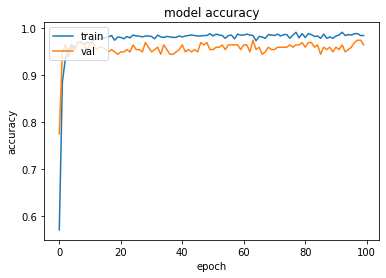

In [161]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

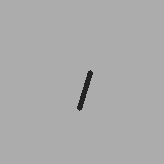

In [204]:
#read in image for prediction
os.chdir('C:\\Users\\George\\Documents\\Python Scripts\\DeepTest\\ValidationSet')
img_num = np.random.randint(0,200)
filename = 'test_{}.png'.format(img_num)
test_img = Image.open(filename)
display(test_img)

In [205]:
#convert image to array and predict with model
test_img_arr = np.array([np.asarray(test_img,dtype = "float32")/255.0])
bb_raw = model.predict(test_img_arr)
bb = bb_raw[0]*164
print(bb)

[81.54418  75.84011  11.144271 34.244534]


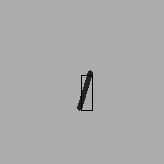

In [206]:
#display prediction
results = Draw(test_img)
results.rectangle([(bb[0],bb[1]),(bb[0]+bb[2],bb[1]+bb[3])])
display(test_img)